In [1]:
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

import torch
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch.nn.init as init

from torchsummary import summary
import sys

curdir = "C:/Users/dinle/Code/AI/Aicrowd/mosquito_alert/"
sys.path.append(curdir + "mnist")

from mnist import load_mnist
torch.cuda.is_available()

True

In [2]:
# data_file = "C:/Users/dinle/Code/AI/NodeLayer/dataset/mosquito/tensor_image.pt"
# all_data = torch.load(data_file)
# all_data = all_data[:5000]
# torch.save(all_data, "C:/Users/dinle/Code/AI/Aicrowd/mosquitoAlert/tensor_image_1.pt")

In [3]:
def set_data(data_name, cut=5000, tr_lr=0.8):
    if data_name == 'mnist':
        (tr_data, tr_lb), (ts_data, ts_lb) = load_mnist(normalize=True)
        tr_data = tr_data.reshape(-1,1,28,28)
        ts_data = ts_data.reshape(-1,1,28,28)
        tr_data = torch.tensor(tr_data)
        tr_lb = torch.tensor(tr_lb)
        ts_data = torch.tensor(ts_data)
        ts_lb = torch.tensor(ts_lb)
    elif data_name == 'mosquito':
        # DATA
        data_file = curdir + "tensor_image.pt"
        # .pt 파일을 엽니다.
        all_data = torch.load(data_file)
        all_data = torch.tensor(all_data[:cut])
        
        # label
        lb_file = curdir + "phase2_train_v0.csv"
        df = pd.read_csv(lb_file)
        all_lb = df['class_label']
        class_num = {
            "aegypti":      0,
            "albopictus":   1,
            "anopheles":    2,
            "culex":        3,
            "culiseta":     4,
            "japonicus/koreicus": 5
        }
        all_lb = all_lb.map(class_num)
        all_lb = torch.tensor(all_lb[:cut])
        tr_cut = int(cut * 0.8)
        # 분리
        tr_data = all_data[:tr_cut]
        tr_lb = all_lb[:tr_cut]
        ts_data = all_data[tr_cut:]
        ts_lb = all_lb[tr_cut:]
    else:
        assert 'No data'
        
    print(tr_data.shape, tr_lb.shape, ts_data.shape, ts_lb.shape)

    tr_dataset = TensorDataset(tr_data, tr_lb)
    ts_dataset = TensorDataset(ts_data, ts_lb)
    train_loader = DataLoader(tr_dataset,batch_size=batch_size)
    test_loader = DataLoader(ts_dataset,batch_size=batch_size)
    
    return train_loader, test_loader, (tuple(tr_data.shape[1:]), int(max(tr_lb))+1)

def calculate_accuracy(output, target):
    _, predicted = torch.max(output, 1)
    correct = (predicted == target).sum().item()
    accuracy = correct / target.size(0)
    return accuracy

def imshow(ts_img):
    np_img = ts_img.numpy()
    np_img = (np_img * 225).astype(np.uint8)
    plt.imshow(np_img.transpose(1,2,0))
    plt.show()

def show_result(img, y, t):
    _, p = torch.max(y, 1)
    correct = (p == t).sum().item()
    accuracy = correct / t.size(0)
    imshow(img[0])
    print(p)
    print(t)
    print(correct)
    print(accuracy)

def smooth_curve(x):
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

def plot(label, datas, *y_lim):
    # datas = smooth_curve(datas)
    plt.plot(datas, markevery=50)
    plt.xlabel("iter")
    plt.ylabel(label)
    if y_lim:
        plt.ylim(y_lim)
    plt.show()

In [4]:
data_name = 'mosquito'
# data_name = 'mnist'

cut = 4000
tr_lr = 0.8
batch_size = 40

whole_epoch = 1
tr_print = 1
ts_print = max(1, int(tr_print * (1 - tr_lr)))

learning_rate = 0.001
base_fn = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_loader, test_loader, size = set_data(data_name, cut, tr_lr)
input_size = size[0]
lb_size = size[1]
# input_size = (3, 224, 224)
# lb_size = 6
if torch.cuda.is_available():
    print("Train with GPU")
else:
    print("Train with CPU")
print(f"Input Data Shape: {input_size}\nClass Number: {lb_size}")
# # 학습용 이미지를 무작위로 가져오기
# for i,[image,label] in enumerate(train_loader):
#     # 이미지 보여주기
#     imshow(torchvision.utils.make_grid(image))
#     
#     # 정답(label) 출력
#     print(' '.join('%5s' % label[i] for i in range(batch_size)))
#     if 1<i:
#         break

C:\Users\dinle\AppData\Local\Temp\ipykernel_36916\4077969317.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_data = torch.tensor(all_data[:cut])


torch.Size([3200, 3, 224, 224]) torch.Size([3200]) torch.Size([800, 3, 224, 224]) torch.Size([800])
Train with GPU
Input Data Shape: (3, 224, 224)
Class Number: 6


In [6]:
def conv_2_block(in_ch,out_ch,kernel_size,stride,padding,pool_size,data_size):
    model = nn.Sequential(
        nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding),
        nn.ReLU(),
        # nn.MaxPool2d(pool_size,pool_size),
        nn.Conv2d(out_ch,out_ch,kernel_size,stride,padding),
        nn.ReLU(),
        nn.MaxPool2d(pool_size,pool_size),
        nn.BatchNorm2d(out_ch)
    )
    output_size = ((data_size[1] - kernel_size + 2 * padding) // stride) + 1
    # output_size = (output_size - pool_size) // pool_size + 1
    output_size = ((output_size- kernel_size + 2 * padding) // stride) + 1
    output_size = (output_size - pool_size) // pool_size + 1
    
    data_size[0] = out_ch
    data_size[1] = output_size
    data_size[2] = output_size
    
    return model

def conv_3_block(in_ch,out_ch,kernel_size,stride,padding,pool_size,data_size):
    model = nn.Sequential(
        nn.Conv2d(in_ch,out_ch,kernel_size,stride,padding),
        nn.ReLU(),
        nn.Conv2d(out_ch,out_ch,kernel_size,stride,padding),
        nn.ReLU(),
        nn.Conv2d(out_ch,out_ch,kernel_size,stride,padding),
        nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.BatchNorm2d(out_ch)
    )
    data_size[0] = out_ch
    output_size = ((data_size[1] - kernel_size + 2 * padding) // stride) + 1
    output_size = ((output_size - kernel_size + 2 * padding) // stride) + 1
    output_size = ((output_size - kernel_size + 2 * padding) // stride) + 1
    output_size = (output_size - pool_size) // pool_size + 1
    
    data_size[0] = out_ch
    data_size[1] = output_size
    data_size[2] = output_size
    
    return model

class VGG16(nn.Module):
    def __init__(self, input_size, lb_size, base_fn=64, kernel_size=3, stride=1, padding=1, pool_size=2):
        super(VGG16, self).__init__()
        self.data_size = list(input_size).copy()
        self.feature = nn.Sequential(
            conv_2_block(input_size[0], base_fn, kernel_size, stride, padding, pool_size, self.data_size),
            conv_2_block(self.data_size[0], 2*base_fn, kernel_size, stride, padding, pool_size, self.data_size),
            conv_3_block(self.data_size[0], 4*base_fn, kernel_size, stride, padding, pool_size, self.data_size), 
            conv_3_block(self.data_size[0], 8*base_fn, kernel_size, stride, padding, pool_size, self.data_size), 
            conv_3_block(self.data_size[0], 8*base_fn, kernel_size, stride, padding, pool_size, self.data_size), 
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(self.data_size[0] * self.data_size[1] * self.data_size[2],4096),
            nn.ReLU(True),
            # nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.BatchNorm1d(1000),
            nn.ReLU(True),
            # nn.Dropout(),
            nn.Linear(1000, lb_size),
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x
    
class VGG11(nn.Module):
    def __init__(self, input_size, lb_size, base_fn=64, kernel_size=3, stride=1, padding=1, pool_size=2):
        super(VGG11, self).__init__()
        self.data_size = list(input_size).copy()
        self.feature = nn.Sequential(
            conv_2_block(input_size[0], base_fn, kernel_size, stride, padding, pool_size, self.data_size), 
            conv_3_block(self.data_size[0], 2*base_fn, kernel_size, stride, padding, pool_size, self.data_size), 
            conv_3_block(self.data_size[0], 4*base_fn, kernel_size, stride, padding, pool_size, self.data_size), 
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(self.data_size[0] * self.data_size[1] * self.data_size[2],4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1000, lb_size),
        )
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        x = self.feature(x)
        #print(x.shape)
        x = x.view(x.size(0), -1)
        #print(x.shape)
        x = self.fc_layer(x)
        return x

In [7]:
# VGG
model = VGG16(input_size, lb_size, base_fn).to(device)
print(model)
summary(model, input_size, device=device.type)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

VGG16(
  (feature): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

In [8]:
tr_loss_list = []
tr_acc_list = []
for i in range(whole_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        t = label.to(device)
        optimizer.zero_grad()
        y = model.forward(x)
        loss = loss_func(y, t)
        tr_loss_list.append(loss.cpu().detach().numpy())
        
        loss.backward()
        optimizer.step()
    
        accuracy = calculate_accuracy(y, t) 
        tr_acc_list.append(accuracy)
        if j %  tr_print ==0 or j == (len(train_loader)-1):
            print(f'Epoch [{i + 1}/{whole_epoch}], {batch_size}Batch [{j + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
            # show_result(image, y, t)

Epoch [1/1], 40Batch [1/80], Loss: 2.7223, Accuracy: 0.1500
Epoch [1/1], 40Batch [2/80], Loss: 4.5856, Accuracy: 0.0000
Epoch [1/1], 40Batch [3/80], Loss: 2.5646, Accuracy: 0.3750
Epoch [1/1], 40Batch [4/80], Loss: 1.9548, Accuracy: 0.2000
Epoch [1/1], 40Batch [5/80], Loss: 1.2985, Accuracy: 0.4000
Epoch [1/1], 40Batch [6/80], Loss: 1.9407, Accuracy: 0.4750
Epoch [1/1], 40Batch [7/80], Loss: 1.2405, Accuracy: 0.5000
Epoch [1/1], 40Batch [8/80], Loss: 1.5980, Accuracy: 0.3250
Epoch [1/1], 40Batch [9/80], Loss: 1.5167, Accuracy: 0.4000
Epoch [1/1], 40Batch [10/80], Loss: 1.2934, Accuracy: 0.5750
Epoch [1/1], 40Batch [11/80], Loss: 1.5796, Accuracy: 0.4250
Epoch [1/1], 40Batch [12/80], Loss: 1.5414, Accuracy: 0.4500
Epoch [1/1], 40Batch [13/80], Loss: 1.3912, Accuracy: 0.4750
Epoch [1/1], 40Batch [14/80], Loss: 1.1983, Accuracy: 0.4750
Epoch [1/1], 40Batch [15/80], Loss: 1.2161, Accuracy: 0.2500
Epoch [1/1], 40Batch [16/80], Loss: 1.2720, Accuracy: 0.3750
Epoch [1/1], 40Batch [17/80], Los

In [9]:
ts_loss_list = []
ts_acc_list = []

for j,[image,label] in enumerate(test_loader):
    x = image.to(device)
    t = label.to(device)
    optimizer.zero_grad()
    y = model.forward(x)
    loss = loss_func(y, t)
    ts_loss_list.append(loss.cpu().detach().numpy())

    accuracy = calculate_accuracy(y, t) 
    ts_acc_list.append(accuracy)
    if j % ts_print ==0 or j == (len(test_loader)-1):
        print(f'{batch_size}Batch [{j + 1}/{len(test_loader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
        # show_result(image, y, t)

40Batch [1/20], Loss: 1.1761, Accuracy: 0.3250
40Batch [2/20], Loss: 1.5551, Accuracy: 0.2750
40Batch [3/20], Loss: 0.9065, Accuracy: 0.4500
40Batch [4/20], Loss: 1.1294, Accuracy: 0.3500
40Batch [5/20], Loss: 1.1514, Accuracy: 0.3750
40Batch [6/20], Loss: 0.9956, Accuracy: 0.4750
40Batch [7/20], Loss: 1.1897, Accuracy: 0.3000
40Batch [8/20], Loss: 1.4432, Accuracy: 0.4000
40Batch [9/20], Loss: 1.3250, Accuracy: 0.5750
40Batch [10/20], Loss: 1.0662, Accuracy: 0.4500
40Batch [11/20], Loss: 1.4240, Accuracy: 0.5000
40Batch [12/20], Loss: 1.1211, Accuracy: 0.5750
40Batch [13/20], Loss: 1.1928, Accuracy: 0.4500
40Batch [14/20], Loss: 1.0699, Accuracy: 0.5000
40Batch [15/20], Loss: 1.0575, Accuracy: 0.5500
40Batch [16/20], Loss: 1.2075, Accuracy: 0.4750
40Batch [17/20], Loss: 0.9249, Accuracy: 0.4250
40Batch [18/20], Loss: 1.1203, Accuracy: 0.4750
40Batch [19/20], Loss: 1.1442, Accuracy: 0.4250
40Batch [20/20], Loss: 1.4209, Accuracy: 0.3750


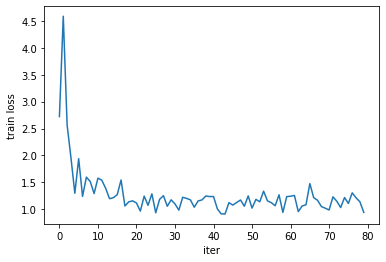

In [10]:
plot('train loss', tr_loss_list)

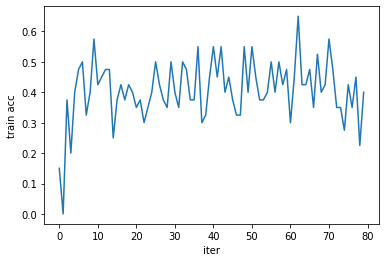

In [11]:
plot('train acc', tr_acc_list)

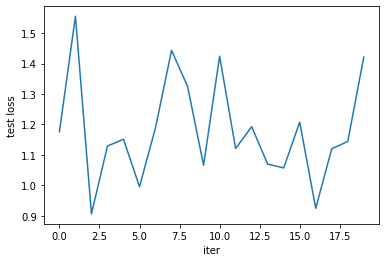

In [12]:
plot('test loss', ts_loss_list)

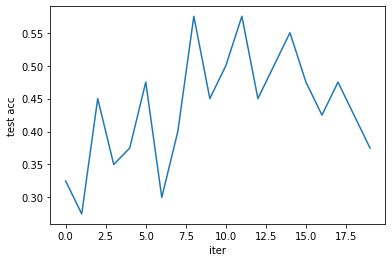

In [13]:
plot('test acc', ts_acc_list)

In [ ]:
torch.save(model.state_dict(), curdir + 'model_weights.pt')